## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('bitcoin.csv')
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Open')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df_close = df['Close'].values.reshape(-1, 1)

df

,Close
Date,
2020-06-01,10.1893
2020-06-02,9.5276
2020-06-03,9.6672
2020-06-04,9.7944
2020-06-05,9.6312
...,...
2022-05-28,29.0271
2022-05-29,29.4652
2022-05-30,31.7233


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Close'] = arima_sc.fit_transform(df_close)
df_scaled

,Close
Date,
2020-06-01,-1.526877
2020-06-02,-1.566503
2020-06-03,-1.558143
2020-06-04,-1.550526
2020-06-05,-1.560299
...,...
2022-05-28,-0.398775
2022-05-29,-0.372539
2022-05-30,-0.237313


# Vẽ đồ thị

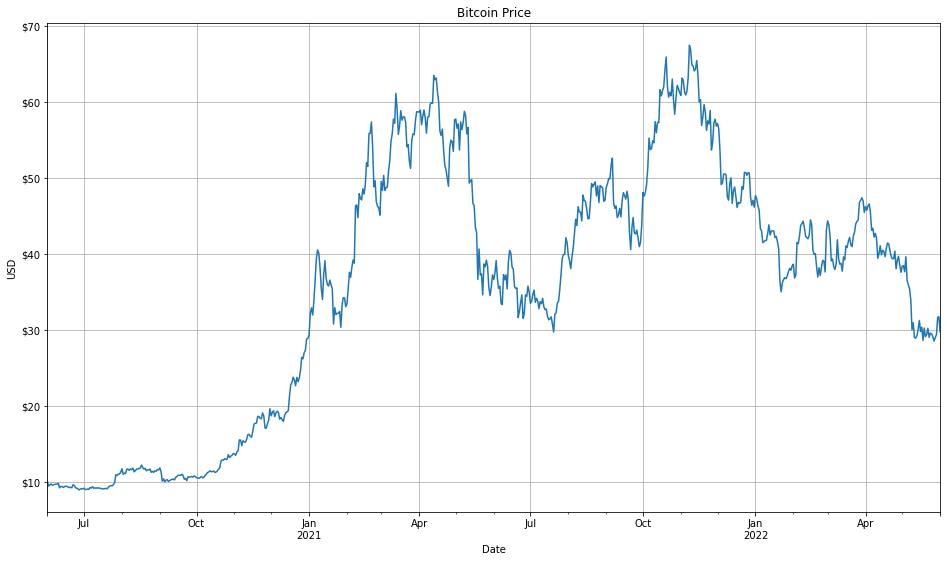

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 0.9)], df_scaled[(int)(len(df_scaled) * 0.9):]
index_test = df_scaled.index[(int)(len(df_scaled) * 0.9):]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (657, 1)
test shape:  (74, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['Close'],'Bitcoin Price')

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.557883
p-value                     0.504708
Number of lags used         0.000000
Number of observations    656.000000
critical value (1%)        -3.440358
critical value (5%)        -2.865956
critical value (10%)       -2.569122
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

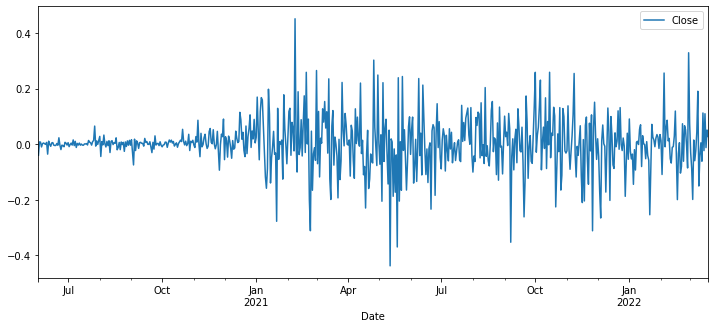

In [8]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'Bitcoin Price First Difference')

Augmented Dickey-Fuller Test: Bitcoin Price First Difference
ADF test statistic        -26.501540
p-value                     0.000000
Number of lags used         0.000000
Number of observations    655.000000
critical value (1%)        -3.440373
critical value (5%)        -2.865963
critical value (10%)       -2.569125
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1258.199, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1262.241, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1261.104, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1261.123, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1263.581, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1259.136, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.127 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  657
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 632.790
Date:                Mon, 27 Jun 2022   AIC                          -1263.581
Time:                        00:38:57   BIC                          -1259.095
Sample:                             0   HQIC                         -1261.841
                                - 657                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0085      0.000     29.420      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):               298.68
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):              10.01   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(test))
pred


array([0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098, 0.39206098,
       0.39206098, 0.39206098, 0.39206098, 0.39206098])

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

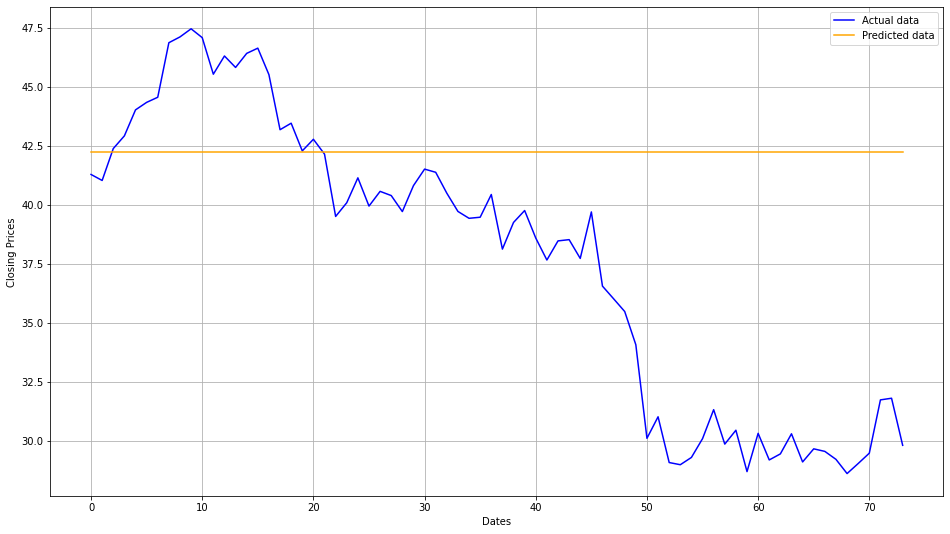

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 5.95
MAPE: 18.27%
MSE: 57.85
RMSE: 7.61
R2: -0.55


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2022-03-20,41.2760,42.233,-0.9570
2022-03-21,41.0220,42.233,-1.2110
2022-03-22,42.3730,42.233,0.1400
2022-03-23,42.9120,42.233,0.6790
2022-03-24,44.0130,42.233,1.7800
...,...,...,...
2022-05-28,29.0271,42.233,-13.2059
2022-05-29,29.4652,42.233,-12.7678
2022-05-30,31.7233,42.233,-10.5097


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
Date,,,
2022-03-20,41.2760,42.233,-0.9570
2022-03-21,41.0220,42.233,-1.2110
2022-03-22,42.3730,42.233,0.1400
2022-03-23,42.9120,42.233,0.6790
2022-03-24,44.0130,42.233,1.7800
...,...,...,...
2022-05-28,29.0271,42.233,-13.2059
2022-05-29,29.4652,42.233,-12.7678
2022-05-30,31.7233,42.233,-10.5097


# Vẽ đồ thị thể hiện sai số

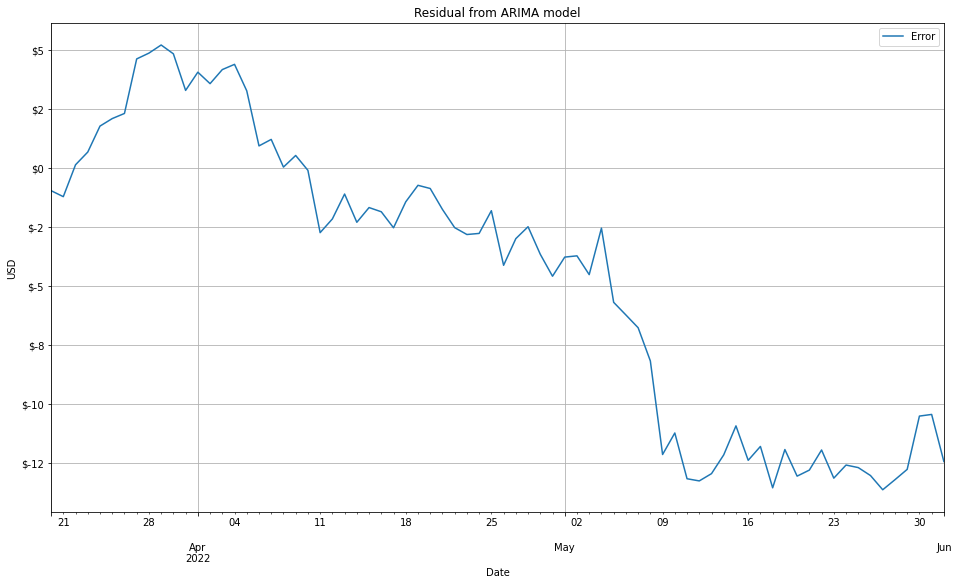

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[ -0.957 ],
       [ -1.211 ],
       [  0.14  ],
       [  0.679 ],
       [  1.78  ],
       [  2.098 ],
       [  2.315 ],
       [  4.626 ],
       [  4.872 ],
       [  5.216 ],
       [  4.842 ],
       [  3.292 ],
       [  4.064 ],
       [  3.578 ],
       [  4.174 ],
       [  4.396 ],
       [  3.273 ],
       [  0.94  ],
       [  1.215 ],
       [  0.042 ],
       [  0.534 ],
       [ -0.095 ],
       [ -2.736 ],
       [ -2.155 ],
       [ -1.1   ],
       [ -2.297 ],
       [ -1.673 ],
       [ -1.851 ],
       [ -2.53  ],
       [ -1.43  ],
       [ -0.73  ],
       [ -0.865 ],
       [ -1.751 ],
       [ -2.524 ],
       [ -2.815 ],
       [ -2.769 ],
       [ -1.806 ],
       [ -4.12  ],
       [ -2.99  ],
       [ -2.485 ],
       [ -3.652 ],
       [ -4.583 ],
       [ -3.772 ],
       [ -3.719 ],
       [ -4.515 ],
       [ -2.545 ],
       [ -5.689 ],
       [ -6.224 ],
       [ -6.765 ],
       [ -8.173 ],
       [-12.138 ],
       [-11.2255],
       [-13.

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (71, 3, 1)
y_train (71, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("bitcoin_9_1.h5")

Epoch 1/300
3/3 [==============================] - 3s 9ms/step - loss: 60.1932
Epoch 2/300
3/3 [==============================] - 0s 7ms/step - loss: 58.9481
Epoch 3/300
3/3 [==============================] - 0s 7ms/step - loss: 57.6127
Epoch 4/300
3/3 [==============================] - 0s 6ms/step - loss: 56.2514
Epoch 5/300
3/3 [==============================] - 0s 7ms/step - loss: 54.5670
Epoch 6/300
3/3 [==============================] - 0s 6ms/step - loss: 52.3961
Epoch 7/300
3/3 [==============================] - 0s 7ms/step - loss: 49.5857
Epoch 8/300
3/3 [==============================] - 0s 7ms/step - loss: 46.0582
Epoch 9/300
3/3 [==============================] - 0s 7ms/step - loss: 40.5627
Epoch 10/300
3/3 [==============================] - 0s 8ms/step - loss: 34.2803
Epoch 11/300
3/3 [==============================] - 0s 7ms/step - loss: 24.9739
Epoch 12/300
3/3 [==============================] - 0s 7ms/step - loss: 15.0071
Epoch 13/300
3/3 [==============================]

In [22]:
model = load_model("bitcoin_9_1.h5")
error_pred = model.predict(x_train)
error_pred

3/3 [==============================] - 1s 5ms/step


array([[ -0.41914424],
       [  0.3066892 ],
       [  1.696732  ],
       [  2.6078453 ],
       [  2.9813814 ],
       [  5.1867557 ],
       [  4.862736  ],
       [  4.4681773 ],
       [  4.0211134 ],
       [  2.9156153 ],
       [  3.7909465 ],
       [  3.579732  ],
       [  4.170115  ],
       [  4.2047734 ],
       [  3.1054046 ],
       [  0.9561624 ],
       [  0.12270671],
       [  0.12736948],
       [ -0.01509674],
       [ -0.27054495],
       [ -2.6881762 ],
       [ -2.2842262 ],
       [ -1.8908443 ],
       [ -2.3275704 ],
       [ -1.6748614 ],
       [ -2.115769  ],
       [ -2.1589923 ],
       [ -1.6739995 ],
       [ -1.4598444 ],
       [ -1.183454  ],
       [ -1.7603729 ],
       [ -2.1355817 ],
       [ -2.394782  ],
       [ -2.8485038 ],
       [ -2.419119  ],
       [ -3.7533178 ],
       [ -3.025021  ],
       [ -3.832161  ],
       [ -3.6937578 ],
       [ -4.0822024 ],
       [ -4.86296   ],
       [ -5.1184816 ],
       [ -4.9908514 ],
       [ -3

In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2022-03-20,41.2760,42.233,-0.9570,-0.419144
2022-03-21,41.0220,42.233,-1.2110,0.306689
2022-03-22,42.3730,42.233,0.1400,1.696732
2022-03-23,42.9120,42.233,0.6790,2.607845
2022-03-24,44.0130,42.233,1.7800,2.981381
...,...,...,...,...
2022-05-25,29.5406,42.233,-12.6924,-12.787503
2022-05-26,29.2035,42.233,-13.0295,-12.413600
2022-05-27,28.6012,42.233,-13.6318,-12.047994


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
Date,,,,,
2022-03-20,41.2760,42.233,-0.9570,-0.419144,41.813856
2022-03-21,41.0220,42.233,-1.2110,0.306689,42.539689
2022-03-22,42.3730,42.233,0.1400,1.696732,43.929732
2022-03-23,42.9120,42.233,0.6790,2.607845,44.840845
2022-03-24,44.0130,42.233,1.7800,2.981381,45.214381
...,...,...,...,...,...
2022-05-25,29.5406,42.233,-12.6924,-12.787503,29.445497
2022-05-26,29.2035,42.233,-13.0295,-12.413600,29.819400
2022-05-27,28.6012,42.233,-13.6318,-12.047994,30.185006


# Vẽ đồ thị

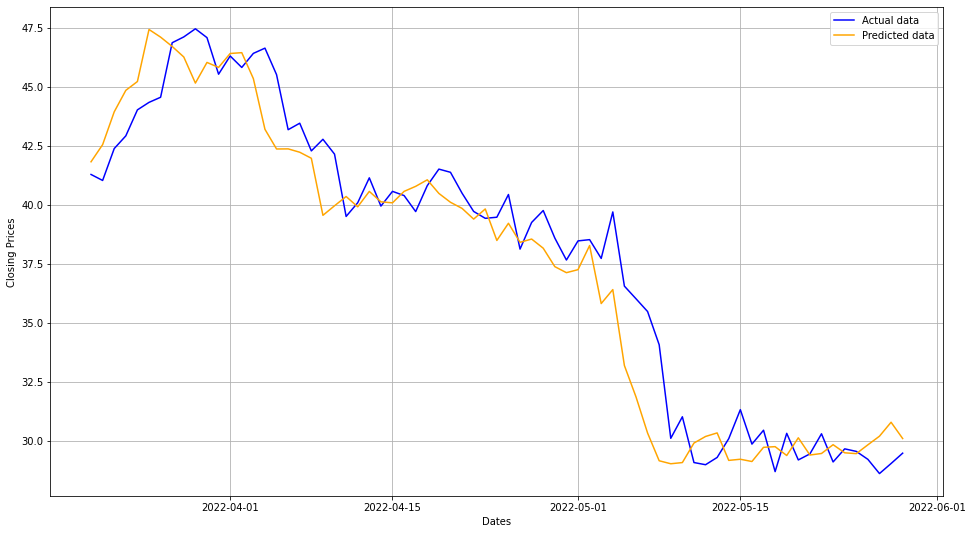

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1.29
MAPE: 3.43%
MSE: 2.93
RMSE: 1.71
R2: 0.92


# Lấy 3 ngày cuối ra để dự báo

In [27]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -13.6318
2022-05-28   -13.2059
2022-05-29   -12.7678
Name: Error, dtype: float64

# Đưa về ma trận

In [28]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-13.6318],
        [-13.2059],
        [-12.7678]]])

In [29]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 50ms/step


array([-12.047995], dtype=float32)

# So sánh kết quả dự đoán với giá trị thực

In [30]:
y_arima = df_pred.copy()
y_arima = y_arima.tail(4).head(1)
y_arima

,Actual,ARIMA,Error
Date,,,
2022-05-29,29.4652,42.233,-12.7678


In [31]:
y_arima['Final_LSTM'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_LSTM
Date,,,,
2022-05-29,29.4652,42.233,-12.7678,30.185005


# Ghi ra file csv

In [32]:
df.to_csv("btc_processed_data_9_1.csv")
df_scaled.to_csv("btc_scaled_data_9_1.csv")
df_pred.to_csv("btc_ARIMA-PRED_9_1.csv")
df_lstm.to_csv("btc_LSTM_PRED_9_1.csv")
y_arima.to_csv("btc_Forecast_9_1.csv")